In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Install colorcet if not already installed
%pip install colorcet
import colorcet as cc

# Load the dataset
df = pd.read_csv('src/merge_imdb.csv')

# Display the first few rows of the dataframe
print(df.head())

# Display basic information about the dataframe
print(df.info())

# Display summary statistics of the dataframe
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Display the column names
print(df.columns)

Note: you may need to restart the kernel to use updated packages.
      imdbID  isAdult                   movie_name  movie_date  box_office  \
0  tt0000679        0  thefairylogueandradio-plays        1908         NaN   
1  tt0002646        0                     atlantis        1913         NaN   
2  tt0003022        0                      ivanhoe        1913         NaN   
3  tt0004099        0  hismajesty,thescarecrowofoz        1914         NaN   
4  tt0004182        0                    thejungle        1914         NaN   

   runtime                           language                 countries  \
0    120.0                   English Language  United States of America   
1    113.0  English Language, Danish Language                   Denmark   
2      NaN      Silent film, English Language  United States of America   
3     60.0                   English Language  United States of America   
4      NaN      Silent film, English Language                       NaN   

              

In [42]:
# Display basic statistics for each column in the dataframe
print(df.describe(include='all'))

           imdbID  isAdult     movie_name   movie_date    box_office  \
count        1927   1927.0           1927  1927.000000  7.640000e+02   
unique       1927      NaN           1689          NaN           NaN   
top     tt0000679      NaN  lesmisérables          NaN           NaN   
freq            1      NaN              8          NaN           NaN   
mean          NaN      0.0            NaN  1970.646601  7.486235e+07   
std           NaN      0.0            NaN    25.553015  1.404628e+08   
min           NaN      0.0            NaN  1908.000000  4.606000e+04   
25%           NaN      0.0            NaN  1952.000000  6.538990e+06   
50%           NaN      0.0            NaN  1971.000000  2.392428e+07   
75%           NaN      0.0            NaN  1993.000000  8.720187e+07   
max           NaN      0.0            NaN  2013.000000  1.119930e+09   

            runtime          language                 countries   genres  \
count   1833.000000              1852                      

In [27]:
# Separate the genres by each comma and explode the list into separate rows
df['genres'] = df['genres'].str.split(', ')
df_genres_exploded = df.explode('genres')

# Group by 'genres' and count the number of movies in each genre
genre_counts = df_genres_exploded['genres'].value_counts()

In [28]:
# Load the genre categories from a JSON file
with open('data/genre_categories.json', 'r') as file:
    genre_categories = json.load(file)

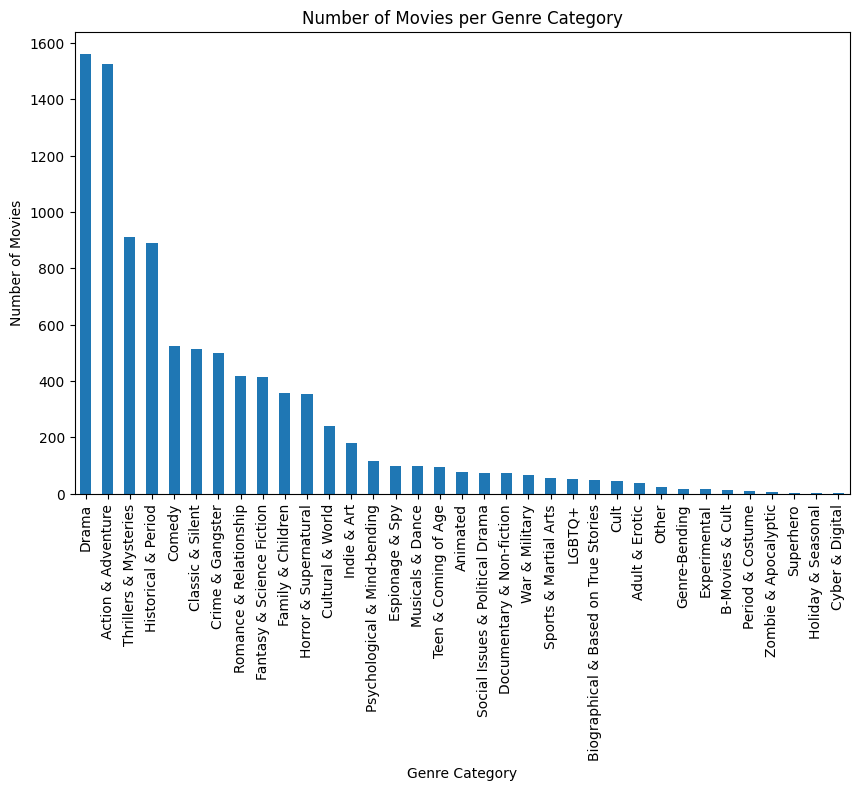

In [39]:
# Map genres to categories
df_genres_exploded['category'] = df_genres_exploded['genres'].map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Count the number of movies in each genre category
genre_category_counts = df_genres_exploded['category'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
genre_category_counts.sort_values(ascending=False).plot(kind='bar')
plt.title('Number of Movies per Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()

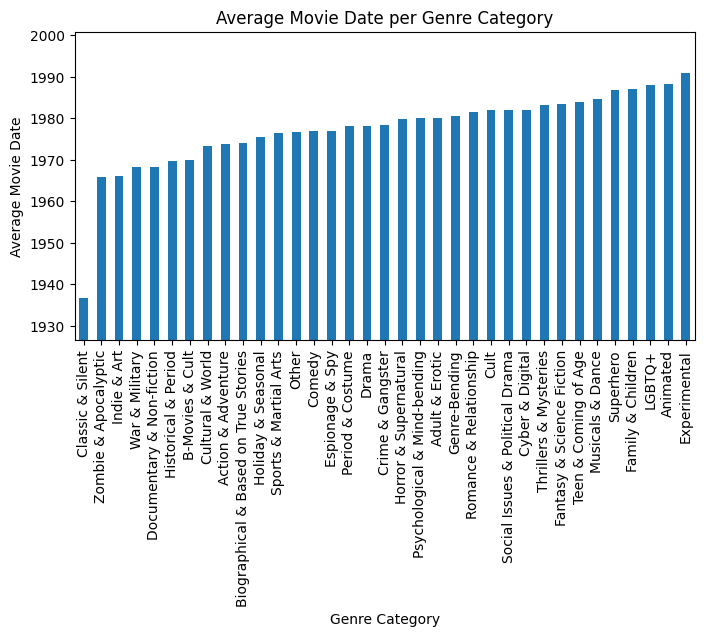

In [29]:
# Calculate the average movie date for each genre category
average_movie_date = df_genres_exploded.groupby('genres')['movie_date'].mean()

# Map genres to categories
average_movie_date_category = average_movie_date.reset_index()
average_movie_date_category['category'] = average_movie_date_category['genres'].map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Calculate the average movie date for each category
average_movie_date_category = average_movie_date_category.groupby('category')['movie_date'].mean()

# Sort the average movie date by descending order
average_movie_date_category = average_movie_date_category.sort_values(ascending=True)

# Plot the average movie date for each genre category
plt.figure(figsize=(8, 4))
average_movie_date_category.plot(kind='bar')
plt.title('Average Movie Date per Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Average Movie Date')
plt.xticks(rotation=90)
plt.ylim(average_movie_date_category.min() - 10, average_movie_date_category.max() + 10)
plt.show()

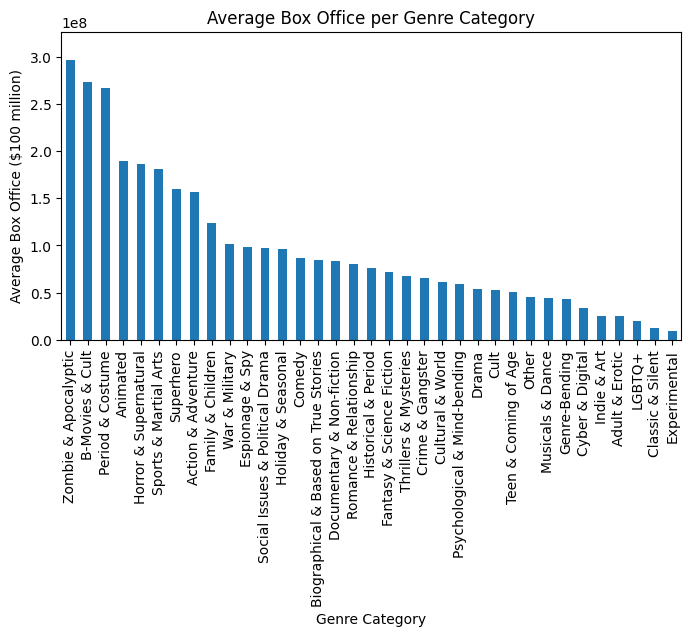

In [30]:
# Calculate the average box office for each genre category
average_box_office = df_genres_exploded.dropna(subset=['box_office']).groupby('genres')['box_office'].mean()

# Map genres to categories
average_box_office_category = average_box_office.reset_index()
average_box_office_category['category'] = average_box_office_category['genres'].map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Calculate the average box office for each category
average_box_office_category = average_box_office_category.groupby('category')['box_office'].mean()

# Sort the average box office by descending order
average_box_office_category = average_box_office_category.sort_values(ascending=False)

# Plot the average box office for each genre category
plt.figure(figsize=(8, 4))
average_box_office_category.plot(kind='bar')
plt.title('Average Box Office per Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Average Box Office ($100 million)')
plt.xticks(rotation=90)
plt.ylim(0, average_box_office_category.max() + average_box_office_category.max()/10)
plt.show()

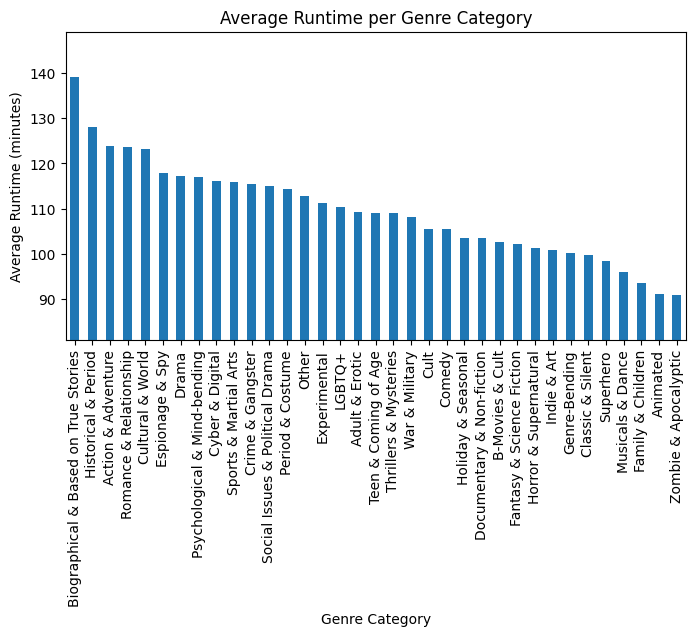

In [31]:
# Calculate the average runtime for each genre category
average_runtime = df_genres_exploded.dropna(subset=['runtime']).groupby('genres')['runtime'].mean()

# Map genres to categories
average_runtime_category = average_runtime.reset_index()
average_runtime_category['category'] = average_runtime_category['genres'].map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Calculate the average runtime for each category
average_runtime_category = average_runtime_category.groupby('category')['runtime'].mean()

# Sort the average runtime by descending order
average_runtime_category = average_runtime_category.sort_values(ascending=False)

# Plot the average runtime for each genre category
plt.figure(figsize=(8, 4))
average_runtime_category.plot(kind='bar')
plt.title('Average Runtime per Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Average Runtime (minutes)')
plt.xticks(rotation=90)
plt.ylim(average_runtime_category.min() - 10, average_runtime_category.max() + 10)
plt.show()

In [32]:
# Separate the languages by each comma and explode the list into separate rows
df_genres_exploded['language'] = df_genres_exploded['language'].str.split(', ')
df_genres_exploded_languages_exploded = df_genres_exploded.explode('language')

# Clean the languages by removing the word "Language"
df_genres_exploded_languages_exploded['language'] = df_genres_exploded_languages_exploded['language'].str.replace(' Language', '')

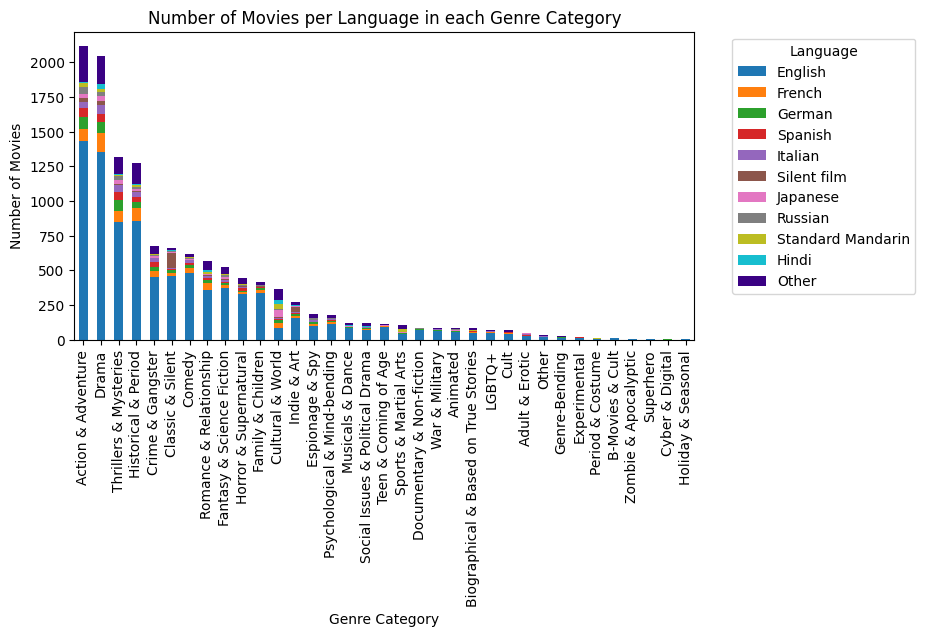

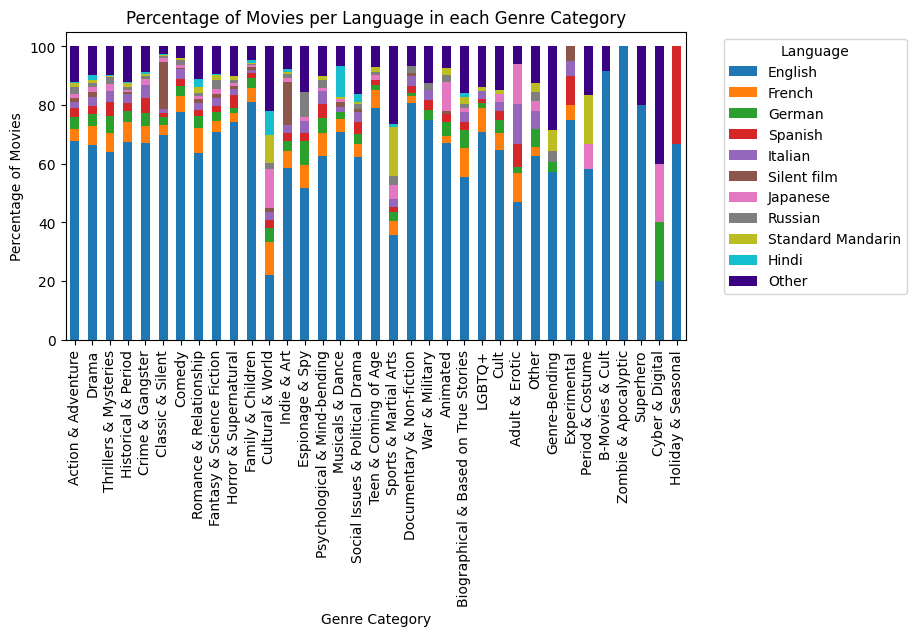

In [40]:
# Group by genre categories and languages, and count the number of movies in each combination
language_counts = df_genres_exploded_languages_exploded.groupby(['genres', 'language']).size().unstack()

# Get the top 10 most used languages
top_languages = language_counts.sum().sort_values(ascending=False).head(10).index

# Map genres to categories
language_counts['category'] = language_counts.index.map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Group by genre categories and languages, and count the number of movies in each combination
language_counts = language_counts.groupby('category').sum()

# Keep only the top 10 languages and group the rest into 'Other'
language_counts['Other'] = language_counts.drop(columns=top_languages).sum(axis=1)
language_counts = language_counts[top_languages.tolist() + ['Other']]

# Sort the genre categories by the total number of movies in descending order
language_counts = language_counts.loc[language_counts.sum(axis=1).sort_values(ascending=False).index]

# Plot the stacked bar chart
unique_languages = language_counts.columns
colors = sns.color_palette(cc.glasbey_category10, n_colors=len(unique_languages))  # Get a unique color for each language

language_counts[unique_languages].plot(kind='bar', stacked=True, figsize=(8, 4), color=colors)
plt.title('Number of Movies per Language in each Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Calculate the percentage of movies in each language for each genre category
language_counts_percentage = language_counts.div(language_counts.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart by percentage
language_counts_percentage[unique_languages].plot(kind='bar', stacked=True, figsize=(8, 4), color=colors)
plt.title('Percentage of Movies per Language in each Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Percentage of Movies')
plt.xticks(rotation=90)
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [34]:
# Separate the countries by each comma and explode the list into separate rows
df_genres_exploded['countries'] = df_genres_exploded['countries'].str.split(', ')
df_genres_exploded_countries_exploded = df_genres_exploded.explode('countries')

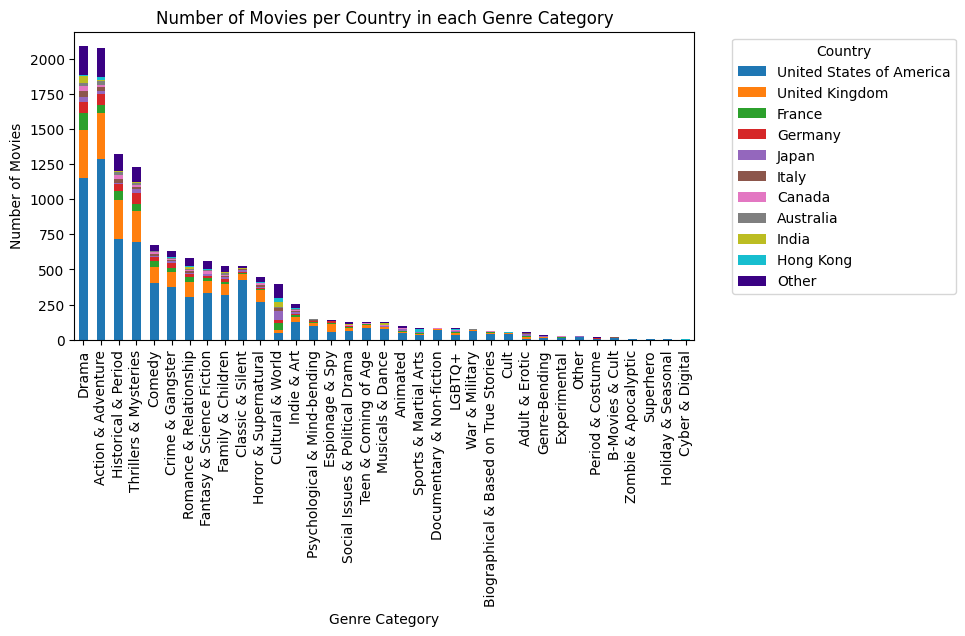

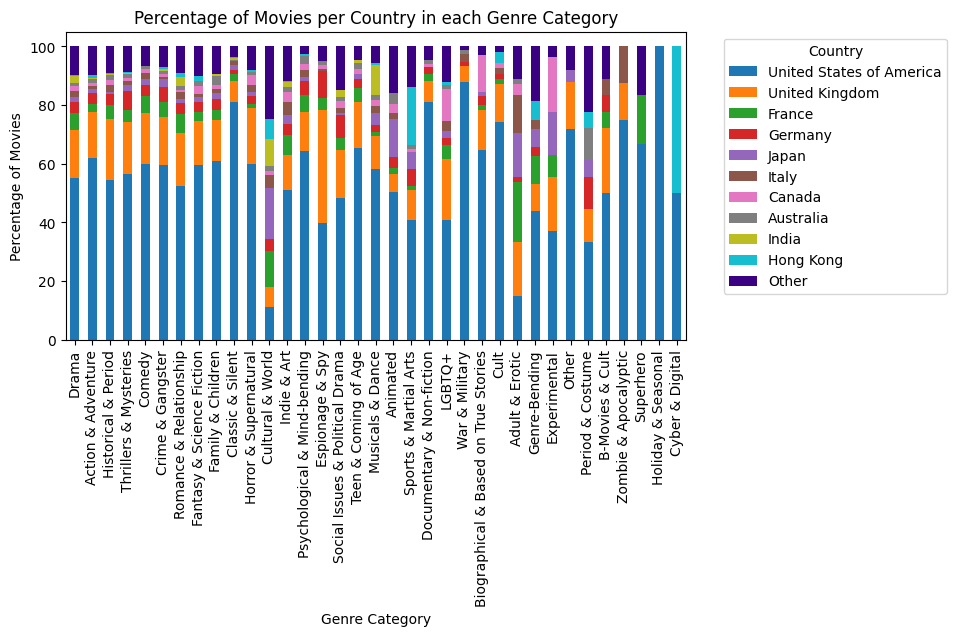

In [41]:
# Group by genre categories and countries, and count the number of movies in each combination
country_counts = df_genres_exploded_countries_exploded.groupby(['genres', 'countries']).size().unstack()

# Get the top 10 most used countries
top_countries = country_counts.sum().sort_values(ascending=False).head(10).index

# Map genres to categories
country_counts['category'] = country_counts.index.map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Group by genre categories and countries, and count the number of movies in each combination
country_counts = country_counts.groupby('category').sum()

# Keep only the top 10 countries and group the rest into 'Other'
country_counts['Other'] = country_counts.drop(columns=top_countries).sum(axis=1)
country_counts = country_counts[top_countries.tolist() + ['Other']]

# Sort the genre categories by the total number of movies in descending order
country_counts = country_counts.loc[country_counts.sum(axis=1).sort_values(ascending=False).index]

# Plot the stacked bar chart
unique_countries = country_counts.columns
colors = sns.color_palette(cc.glasbey_category10, n_colors=len(unique_countries))  # Get a unique color for each country

country_counts[unique_countries].plot(kind='bar', stacked=True, figsize=(8, 4), color=colors)
plt.title('Number of Movies per Country in each Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Calculate the percentage of movies in each country for each genre category
country_counts_percentage = country_counts.div(country_counts.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart by percentage
country_counts_percentage[unique_countries].plot(kind='bar', stacked=True, figsize=(8, 4), color=colors)
plt.title('Percentage of Movies per Country in each Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Percentage of Movies')
plt.xticks(rotation=90)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

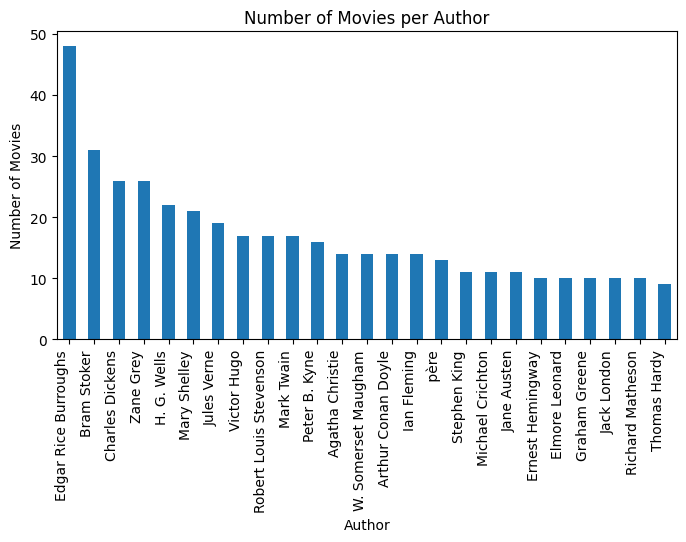

In [36]:
# Get the top 10 authors by the number of movies
top_authors = df['author_book'].value_counts().head(25)

# Plot the bar chart
plt.figure(figsize=(8, 4))
top_authors.plot(kind='bar')
plt.title('Number of Movies per Author')
plt.xlabel('Author')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90, ha='right')
plt.show()

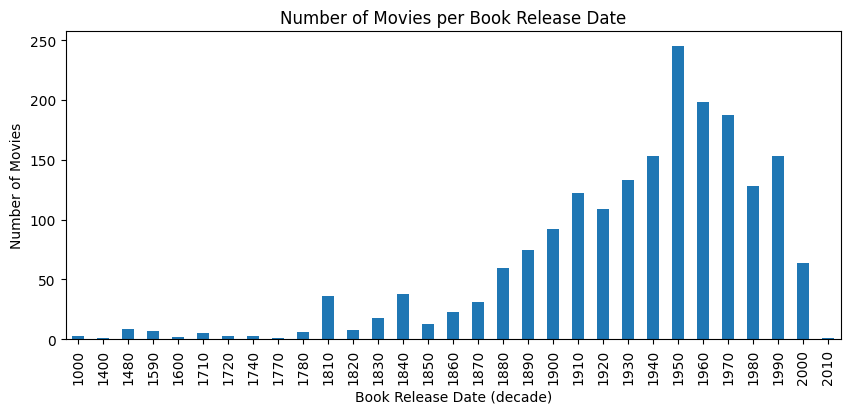

In [37]:
# Extract the first year if the date is in the format xxxx-xxxx
df['year_book'] = df['year_book'].str.split('–').str[0]
df['year_book'] = df['year_book'].str.split('-').str[0]

# Drop rows with NaN values in 'year_book'
df = df.dropna(subset=['year_book'])

# Convert 'year_book' to integer
df['year_book'] = df['year_book'].astype(int)

# Create a new column for the decade
df['decade'] = (df['year_book'] // 10) * 10

# Plot the bar chart grouped by decade
plt.figure(figsize=(10, 4))
df['decade'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Movies per Book Release Date')
plt.xlabel('Book Release Date (decade)')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()